# Laboratorium 4

### Konfiguracja

In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import functools

FIG_EPS = 0.1

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


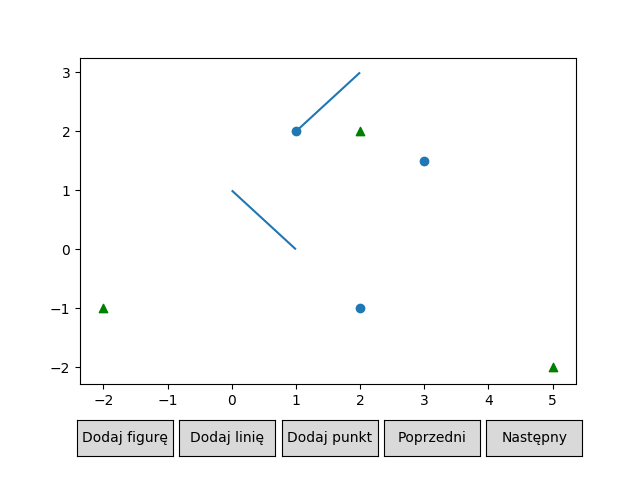

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


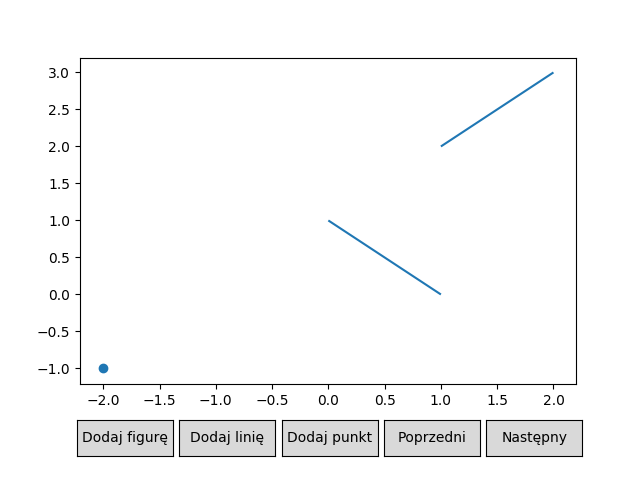

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


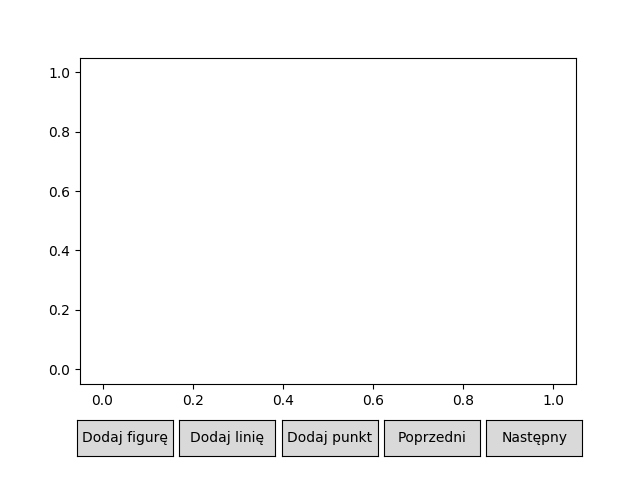

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


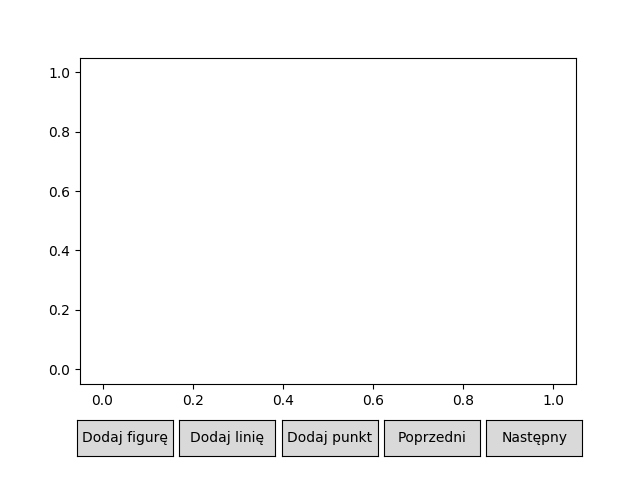

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [67]:
class Point:

    def __init__(self, x:float, y:float) -> None:
        super().__init__()
        self.x = x
        self.y = y

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'

    def set_next(self, point: 'Point'):
        self.next = point

    def set_prev(self, point: 'Point'):
        self.prev = point
        
    def set_chain(self, chain: bool):
        self.chain = chain

    def to_tuple(self):
        return self.x, self.y


class Line:

    def __init__(self, p0: Point, p1: Point) -> None:
        super().__init__()
        self.p0 = p0
        self.p1 = p1

    def get_left(self):
        return self.p0

    def get_right(self):
        return self.p1

    def get_slope(self):
        return (self.p1.y - self.p0.y) / (self.p1.x - self.p0.x)

    def get_b(self):
        return self.p1.y - self.get_slope() * self.p1.x

    def get_y(self, x: float):
        return self.get_slope() * x + self.get_b()

    def __str__(self):
        return '(' + str(self.p0) + ', ' + str(self.p1) + ')'

    def to_tuple(self):
        return self.get_left().to_tuple(), self.get_right().to_tuple()


class Polygon:

    def __init__(self, lines) -> None:
        super().__init__()
        self.lines: List[Line] = []
        self.point_list: List[Point] = []
        for l in lines:
            p0 = Point(l[0][0], l[0][1])
            p1 = Point(l[1][0], l[1][1])
            self.lines.append(Line(p0, p1))
            self.point_list.append(p0)
        for i in range(0, len(self.point_list)):
            self.point_list[i].set_next(self.point_list[(i + 1) % len(self.point_list)])
            self.point_list[i].set_prev(self.point_list[(i - 1)])

    def check_y_monotony(self) -> bool:
        max_y_point = functools.reduce(lambda acc, p: p if p.y > acc.y else acc, self.point_list)
        curr = max_y_point
        curr.set_chain(False)
        while curr.prev.y <= curr.y:
            curr = curr.prev
            curr.set_chain(False)
        lowest_a = curr
        curr = max_y_point
        while curr.next.y <= curr.y:
            curr = curr.next
            curr.set_chain(True)
            if curr == lowest_a:
                return True
        return False
    
    def classify_vertices(self):
        poczatkowe = []
        koncowe = []
        laczace = []
        dzielace = []
        prawidlowe = []
        for p in self.point_list:
            if p.prev.y < p.y > p.next.y:
                if det_3x3(p.prev, p, p.next) > 0:
                    poczatkowe.append(p)
                else:
                    dzielace.append(p)
            elif p.prev.y > p.y < p.next.y:
                if det_3x3(p.prev, p, p.next) > 0:
                    koncowe.append(p)
                else:
                    laczace.append(p)
            else:
                prawidlowe.append(p)
        return [PointsCollection(list(map(lambda p: p.to_tuple(), poczatkowe)), color='green'),
                PointsCollection(list(map(lambda p: p.to_tuple(), koncowe)), color='red'),
                PointsCollection(list(map(lambda p: p.to_tuple(), laczace)), color='blue'),
                PointsCollection(list(map(lambda p: p.to_tuple(), dzielace)), color='black'),
                PointsCollection(list(map(lambda p: p.to_tuple(), prawidlowe)), color='brown')]

    def check_if_belongs(self, p0: Point, p1: Point, p2: Point):
        if p0.chain: 
            return orient(p0, p1, p2) > 0
        else:
            return orient(p0, p1, p2) < 0

    def triangulate(self, scenes):
        if not self.check_y_monotony():
            return
        sorted_vertices = sorted(self.point_list, key=lambda p: p.y, reverse=True)
        S = []
        S.append(sorted_vertices[0])
        S.append(sorted_vertices[1])
        diagonals = []
        for i in range(2, len(sorted_vertices)):
            current_vertex = sorted_vertices[i]
            stack_top = S[-1]
            scenes.append(Scene([PointsCollection(list(map(lambda p: p.to_tuple(), S))), PointsCollection([stack_top.to_tuple()]), PointsCollection([current_vertex.to_tuple()])],
                                [LinesCollection(list(map(lambda l: l.to_tuple(), self.lines))), LinesCollection(list(map(lambda l: l.to_tuple(), diagonals)))]
                ))
            if current_vertex.chain!=stack_top.chain:
                for j in range(0, len(S)):
                    v = S.pop()
                    diagonals.append(Line(current_vertex, v))
                    scenes.append(Scene([PointsCollection(list(map(lambda p: p.to_tuple(), S))), PointsCollection([stack_top.to_tuple()]), PointsCollection([current_vertex.to_tuple()])],
                                [LinesCollection(list(map(lambda l: l.to_tuple(), self.lines))), LinesCollection(list(map(lambda l: l.to_tuple(), diagonals)))]
                    ))
                S.append(sorted_vertices[i - 1])
                S.append(sorted_vertices[i])
            else:
                v = S.pop()
                while S and self.check_if_belongs(current_vertex, S[-1], v):
                    diagonals.append(Line(current_vertex, S[-1]))
                    v=S.pop()
                    scenes.append(Scene([PointsCollection(list(map(lambda p: p.to_tuple(), S))), PointsCollection([v.to_tuple()]), PointsCollection([current_vertex.to_tuple()])],
                                [LinesCollection(list(map(lambda l: l.to_tuple(), self.lines))), LinesCollection(list(map(lambda l: l.to_tuple(), diagonals)))]
                    ))
                S.append(v)
                S.append(current_vertex)
        scenes.append(Scene([PointsCollection([])],
                            [LinesCollection(list(map(lambda l: l.to_tuple(), self.lines))), LinesCollection(list(map(lambda l: l.to_tuple(), diagonals)))]
        ))
        return list(map(lambda p: p.to_tuple(), diagonals))
        

In [54]:

def det_3x3(a:Point, b:Point, c:Point):
    a = (a.x, a.y, 1)
    b = (b.x, b.y, 1)
    c = (c.x, c.y, 1)
    return a[0] * b[1] * c[2] + a[1] * b[2] * c[0] + a[2] * b[0] * c[1] - a[2] * b[1] * c[0] - a[1] * b[0] * c[2] - a[
        0] * b[2] * c[1]


def orient(a: Point, b: Point, c: Point, epsilon=10e-10):
    det = det_3x3(a,b,c)
    if det > epsilon:
        return 1
    if det < -epsilon:
        return -1
    else:
        return det


<IPython.core.display.Javascript object>


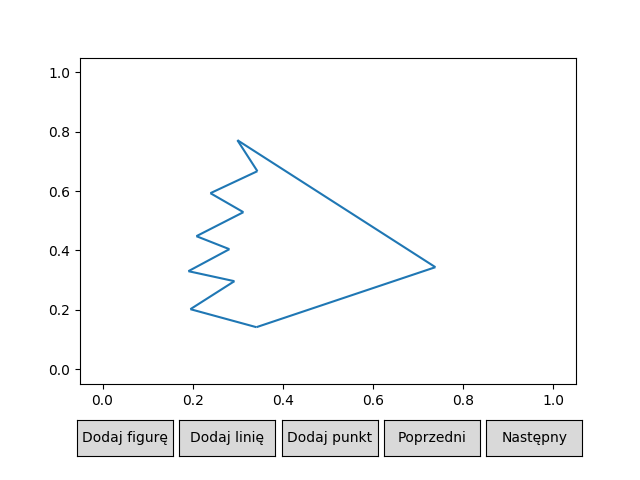

In [58]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [ ]:
polygon = Polygon(plot.get_added_figure()[0].lines)
print(polygon.check_y_monotony())

[[(0.34120973156344503, 0.1414776820762484), (0.7381855380150579, 0.3436835644291896)], [(0.7381855380150579, 0.3436835644291896), (0.2990726347892515, 0.7716860154095817)], [(0.2990726347892515, 0.7716860154095817), (0.343427473498929, 0.6672129761938954)], [(0.343427473498929, 0.6672129761938954), (0.239193602531187, 0.5930708193311505)], [(0.239193602531187, 0.5930708193311505), (0.3123790864021547, 0.5290389565860525)], [(0.3123790864021547, 0.5290389565860525), (0.20814521543441283, 0.4481566036448759)], [(0.20814521543441283, 0.4481566036448759), (0.28133069930538057, 0.404345329135072)], [(0.28133069930538057, 0.404345329135072), (0.19040327995054185, 0.3302031722723268)], [(0.19040327995054185, 0.3302031722723268), (0.29241940898279994, 0.29650219188016996)], [(0.29241940898279994, 0.29650219188016996), (0.1948387638215096, 0.20213944678213075)], [(0.1948387638215096, 0.20213944678213075), (0.34120973156344503, 0.1414776820762484)]]
True


<IPython.core.display.Javascript object>


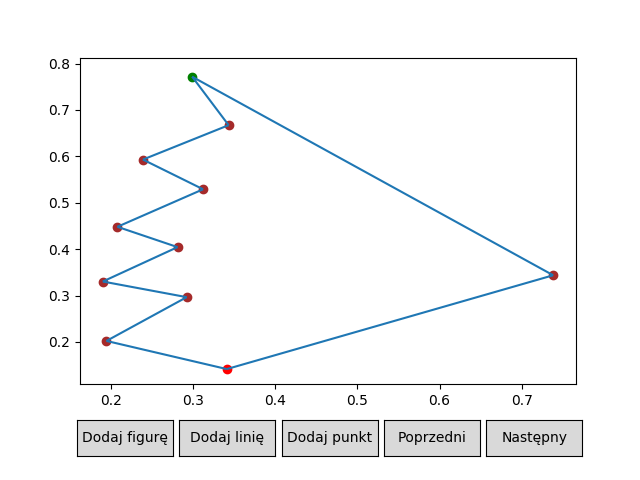

In [62]:
polygon = Polygon(plot.get_added_figure()[0].lines)
plot2 = Plot([Scene(polygon.classify_vertices(),
            plot.get_added_figure())])
plot2.draw()

<IPython.core.display.Javascript object>


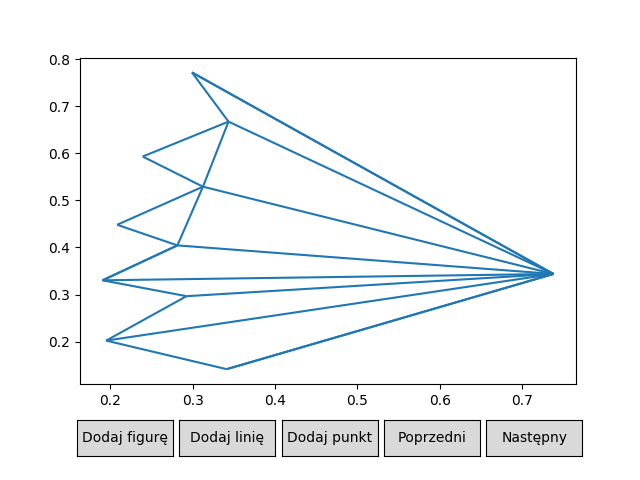

In [68]:
scenes = []
polygon = Polygon(plot.get_added_figure()[0].lines)
polygon.triangulate(scenes)
plot2 = Plot(scenes)
plot2.draw()